#### pix2pix model. applied on EM model

In [ ]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']

#### neptune definition. Caution here is train_on_batch, so the tracking cannot be made by model.fit

In [ ]:
# neptune document

import neptune.new as neptune

run = neptune.init(
    project='leeleeroy/UNet-2D-EM',
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
    name = "UNet2D_128",  
)  # necessary credentials, the name could be used to reproduce the results 

# for callbacks in training

from neptune.new.integrations.tensorflow_keras import NeptuneCallback

neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
# neptune document the hyper param.

PARAMS = {'patchify': 256,
          "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
          'epochs':100,
          'batch_size':16}

# log hyper-parameters
run['hyper-parameters'] = PARAMS
run["sys/tags"].add(["model-type: ", "2D_256"])

In [2]:
import numpy as np
from numpy.random import randint

from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal  #  for normalization
import tensorflow.keras as k
from tensorflow.keras.utils import plot_model  # visualize the model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
# Discriminator

# define generator, discriminator, gan
# use defination wihout sequential, since there are several inputs
# pix2pix is a conditiional GAN with two inputs: image, label (mask)
# gan inputs: images, corresponding labels

# discriminator:
# inputs: image
# outputs: real or fake (1 or 0). Binary classification, using sigmoid activataion
# C64-C128-C256-C512. after last layer, conv to 1-dimensional ouput and activate with sigmoid

def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02) # paper required
    # source image input
    in_src_image = k.layers.Input(shape=image_shape)
    # target image input
    in_target_image = k.layers.Input(shape=image_shape)
    # concatenate images on channel
    merged = k.layers.Concatenate()([in_src_image, in_target_image]) # 256X256X6
    
    # c64. 4x4 kernel, 2x2 stride
    d = k.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)  # !!! here is initualzied
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c128. 4x4 kernel, 2x2 strides
    d = k.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)  # !!! add batch normalization
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c256
    d = k.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # c512. not in original paper, diy for this task
    d = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    
    # second last layer. stride is (1,1)
    d = k.layers.Conv2D(512, (4,4), strides=(1,1), padding='same', kernel_initializer=init)(d)
    d = k.layers.BatchNormalization()(d)
    d = k.layers.LeakyReLU(alpha=0.2)(d)
    # patch out
    d = k.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d) # !!! conv to 1 channel
    patch_out = k.layers.Activation('sigmoid')(d) # patch gan output real or fake, using sigmoid
    
    # define model
    model = k.models.Model([in_src_image, in_target_image], patch_out)  # inputs and outputs
    
    # compile the model
    # trained with batch size 1 under Adam
    # loss of D is weighted by 50% for each model update
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

In [5]:
# Generator

# encoder block for Unet
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # downsampling layer
    g = k.layers.Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    
    # add batch norm accoridng to conditions
    if batchnorm:
        g = k.layers.BatchNormalization()(g, training=True) # ???
        
    # leaky relu activation
    g = k.layers.LeakyReLU(alpha=0.2)(g)
    return g

def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # upsampling layer
    g = k.layers.Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # batch norm
    g = k.layers.BatchNormalization()(g, training=True)
    # dropout according to conditions
    if dropout:
        g = k.layers.Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = k.layers.Concatenate()([g, skip_in])  # combine skip_in, not only AE
    # relu activation
    g = k.layers.Activation('relu')(g)
    return g

# compile generator model in Unet

def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = k.layers.Input(shape=image_shape) # define the shape of input
    
    # encoder: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)  # frist layer not batchnorm. the filters must be feed
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)  # why this structure?
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    
    # bottleneck, no batch norm and relu
    b = k.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = k.layers.Activation('relu')(b)
    
    # decoder: CD512-CD512-CD512-CD512-C256-C128-C64
    d1 = define_decoder_block(b, e7, 512)  # !!! skip in the last layer of encoder
    d2 = define_decoder_block(d1, e6, 512)
    d3 = define_decoder_block(d2, e5, 512)
    d4 = define_decoder_block(d3, e4, 512, dropout=False)
    d5 = define_decoder_block(d4, e3, 256, dropout=False)
    d6 = define_decoder_block(d5, e2, 128, dropout=False)
    d7 = define_decoder_block(d6, e1, 64, dropout=False)
    
    # output
    g = k.layers.Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = k.layers.Activation('tanh')(g)  # generated images is from -1 to 1. remember to change inputs from -1 to 1
    # define model
    model = k.models.Model(in_image, out_image)
    return model

In [6]:
# define GAN

# define combined G and D to update G

def define_gan(g_model, d_model, image_shape):
    # ensure the discriminator is not trainable
    d_model.trainable = False  # 定义为不可训练
#     for layer in d_model.layers:
#         if not isinstance(layer, BatchNormalization):  # ???
#             layer.trainable = False # D cannot be trained in combined GAN, but D can be trained seperately
            
    # define the source image
    in_src = k.layers.Input(shape=image_shape)
    # G: feed images to G
    gen_out = g_model(in_src)
    # D: feed input images and generated images to D
    dis_out = d_model([in_src, gen_out])
    # GAN: src image as input; generated image and ouputs of D as outputs
    model = k.models.Model(in_src, [dis_out, gen_out])
    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    # total loss is sum of adversarial loss (BCE) and L1 loss (MAE)
    # in paper they suggested the weight, BCE vs. L1 = 1:100
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])  
    return model  

In [7]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset  # A is satelite, B is maps
    # random choose
    ix = randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    # generate labels as real
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

In [8]:
def generate_fake_samples(g_model, samples, patch_shape):
    # generate the fake instance
    X = g_model.predict(samples)
    # create labels as 'fake'
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    
    return X, y

In [9]:
# GAN does not converge. Plotting them to find a balance point
# save the generator models during them
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [10]:
def trainModel(g_model, d_model, gan_model, dataset, n_epochs=20, n_batch=1):
    # output shape of the discriminator
    n_patch = d_model.output_shape[1]  # !!! kera's function
    # unpack dataset
    trainA, trainB = dataset
    # number of the baches per epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # number of training iterations
    n_steps = bat_per_epo * n_epochs  # !!! altogether iterations
    
    # enumerate epochs
    for i in range(n_steps):
        # select batch of real images
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate batch of fake images
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update D for real images
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)  # update weights on one batch
        # update D for fake images
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)  # try to generate map images
        
        # update the G
        g_loss, _ , _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        
#         # Log generator loss
#         run["training/g_loss"].log(loss)

#         # Log D loss
#         run["training/batch/acc"].log(acc)
        
        # summarize the performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

#### Main function part. prepare the data

In [11]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io  # !!! from skimage import io
from skimage import img_as_ubyte

# data loading
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'

#### read into raw images

In [12]:
# read into the images 


def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

# DATA_PATH = 'F:/MDC/4.1dataAugNeat/EM/3dem/data/interim/synthetic/'
DATA_PATH = './synthetic/'  # in hemera, only use relative path

data_ids = next(os.walk(DATA_PATH))[1]

import os
import pandas as pd
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|          | 0/3 [00:00<?, ?it/s]/home/li52/.local/lib/python3.6/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


tomo2_focalseries.mrc
tomo3_focalseries.mrc
tomo1_focalseries.mrc
tomo2_groundtruth.mrc
tomo3_groundtruth.mrc


100%|██████████| 3/3 [00:00<00:00, 12.13it/s]

tomo1_groundtruth.mrc


In [13]:
# training dataset raw
# select the firt two (focal+ GT) as training, third as testing
import torchio as tio
from patchify import patchify, unpatchify

train_raw = np.vstack(([focal[0], focal[1]]));trainData = train_raw[...,np.newaxis].transpose((3,1,2,0)); label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]
# print(train_raw.shape)
# padding into the same size
trainIO = tio.ScalarImage(tensor=trainData)
target_shape = 256,256,512
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

(512, 256, 256)
(512, 256, 256)


In [14]:
# testing dataset raw
X_test = focal[2]; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test_label = GT[2]; Y_test_label = (Y_test_label > 0.5).astype(np.float) 

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];
print(test_padd.shape);print(Y_test_label.shape)

(256, 256, 256)
(256, 256, 256)


In [15]:
# preprocess into 3 channels

def pre_channels(dataset):
    stack = []
    dataset = img_as_ubyte(dataset)  # ensure the format
    for i in range(dataset.shape[0]):
        tempImg = np.stack((dataset[i],)*3, axis=-1)
        stack.append(tempImg)
    return stack
    
src_images = pre_channels(train_padd)
tar_images = pre_channels(label)

src_test = pre_channels(test_padd)
tar_test = pre_channels(Y_test_label)


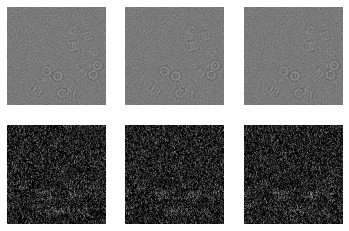

In [16]:
# sanity check

n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(src_images[i], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(tar_images[i])
plt.show()

In [17]:
# transfer list into array for learning
tar_images = np.array(tar_images) 
src_images = np.array(src_images)
tar_test = np.array(tar_test) 
src_test = np.array(src_test) 


In [20]:
import tensorflow as tf
tf.__version__

'1.11.0'

In [18]:
image_shape = src_images.shape[1:]

# define the model
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

gan_model = define_gan(g_model, d_model, image_shape)


TypeError: __call__() got an unexpected keyword argument 'partition_info'

In [17]:
# define the training images
data = [src_images, tar_images]

In [18]:
# rescale into [-1,1], since generatoe use tanh activation
# tanh activation is [-1, 1]

def preprocess_data(data):
    X1, X2 = data[0], data[1]
    # scale from [0, 255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [19]:
dataset = preprocess_data(data)

In [20]:
len(dataset)
test = dataset[0]
print(test.shape)

(512, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


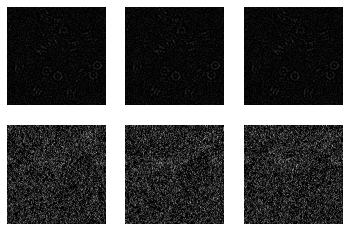

In [40]:
# sanity check

n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(dataset[0][i], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(dataset[1][i])
plt.show()

In [22]:
from datetime import datetime
start1 = datetime.now()
trainModel(g_model, d_model, gan_model, dataset, n_epochs=10, n_batch=1)  # each epochs 512, should be 5120
stop1 = datetime.now()

>1, d1[0.546] d2[0.477] g[101.763]
>2, d1[0.426] d2[0.490] g[100.470]
>3, d1[0.423] d2[0.450] g[98.802]
>4, d1[0.434] d2[0.375] g[97.053]
>5, d1[0.417] d2[0.475] g[95.295]
>6, d1[0.398] d2[0.304] g[93.753]
>7, d1[0.415] d2[0.238] g[91.879]
>8, d1[0.362] d2[0.204] g[90.058]
>9, d1[0.316] d2[0.169] g[87.930]
>10, d1[0.294] d2[0.152] g[86.094]
>11, d1[0.265] d2[0.619] g[84.592]
>12, d1[0.289] d2[0.523] g[82.543]
>13, d1[0.314] d2[0.092] g[81.197]
>14, d1[0.332] d2[0.512] g[78.828]
>15, d1[0.279] d2[0.070] g[77.678]
>16, d1[0.251] d2[0.059] g[76.147]
>17, d1[0.207] d2[0.061] g[74.412]
>18, d1[0.140] d2[0.055] g[72.737]
>19, d1[0.121] d2[0.045] g[70.906]
>20, d1[0.104] d2[0.038] g[69.631]
>21, d1[0.072] d2[0.032] g[68.259]
>22, d1[0.069] d2[0.030] g[66.747]
>23, d1[0.085] d2[0.887] g[65.336]
>24, d1[0.161] d2[0.512] g[64.026]
>25, d1[0.329] d2[0.007] g[63.048]
>26, d1[0.207] d2[0.011] g[61.703]
>27, d1[0.117] d2[0.801] g[59.915]
>28, d1[0.163] d2[0.007] g[59.959]
>29, d1[0.179] d2[0.009] g[

In [23]:
execution_time = stop1 - start1
print("Execution time is: ", execution_time)

g_model.save('./pix2pix/model/pix2pix_10eps.h5')

Execution time is:  0:10:44.233713


#### Loading the data and check the generator

In [24]:
from tensorflow.keras.models import load_model
from numpy.random import randint
from numpy import vstack

In [25]:
# loading the model
model = load_model('./pix2pix/model/pix2pix_10eps.h5')

In [26]:
# plot the source, generated and target images

def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Input-segm-img', 'Output-Generated', 'Original']
    # plot images in row
    for i in range(len(images)):
        plt.subplot(1, 3, 1+i)
        plt.axis('off')
        plt.imshow(images[i,:,:,0], cmap='gray')
        plt.title(titles[i])
    plt.show()

In [27]:
len(dataset)

2

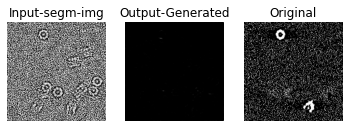

In [38]:
[X1, X2] = dataset
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# generate image from source
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)